In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [16]:
############################################
sweep_root = "../../results/faithfulness_baselines-24-trials"
model_name = "gptj"
############################################

results_file = f"{sweep_root}/{model_name}.json"
fig_dir = "figs"


os.makedirs(fig_dir, exist_ok=True)

with open(results_file, "r") as f:
    results_raw = json.load(f)

In [17]:
def format_results(results_raw):
    results_formatted = {}
    for relation_results in results_raw:
        result = {k: v for k, v in relation_results.items() if k != "trials"}
        result["recall"] = {}
        for trial_result in relation_results["trials"]:
            prompting_approaches = ["zero_shot", "icl"]
            for approach in prompting_approaches:
                if approach not in result["recall"]:
                    result["recall"][approach] = {}
                for method_key in trial_result[approach]:
                    if method_key not in result["recall"][approach]:
                        result["recall"][approach][method_key] = []
                    result["recall"][approach][method_key].append(trial_result[approach][method_key]["recall"])
        
        for approach in prompting_approaches:
            for method_key in result["recall"][approach]:
                result["recall"][approach][method_key] = np.array(result["recall"][approach][method_key]).mean(axis = 0)
        
        results_formatted[relation_results["relation_name"]] = result

    return results_formatted

results_formatted = format_results(results_raw)

In [ ]:
# results_formatted

{'name birthplace': {'relation_name': 'name birthplace',
  'h_layer': 18,
  'beta': 0.254166670764486,
  'expected_recall': 0.9839285714285714,
  'total_samples': 31,
  'prompt_template': ' {} :',
  'recall': {'zero_shot': {'logit_lens': array([0.03253968, 0.0968254 , 0.0968254 , 0.0968254 , 0.0968254 ,
           0.12936508, 0.16190476, 0.17777778, 0.17777778, 0.17777778]),
    'corner': array([0.72619048, 0.83968254, 0.85555556, 0.87142857, 0.87142857,
           0.9031746 , 0.9515873 , 0.9515873 , 0.9515873 , 1.        ]),
    'learned_linear': array([0.24206349, 0.4031746 , 0.46825397, 0.50079365, 0.56428571,
           0.58095238, 0.58095238, 0.61349206, 0.64603175, 0.66190476]),
    'lre_emb': array([0.4531746 , 0.58015873, 0.61190476, 0.65952381, 0.69126984,
           0.74047619, 0.74047619, 0.74047619, 0.75714286, 0.77380952]),
    'lre': array([0.88650794, 0.96746032, 0.96746032, 0.96746032, 0.98412698,
           0.98412698, 0.98412698, 1.        , 1.        , 1.        ]),


In [19]:
dataset = data.load_dataset()
relations_by_name = {r.name: r for r in dataset.relations}

In [20]:
from typing import Literal

def segregate_categorywise(
    results_formatted: dict,
    property_key: Literal["relation_type", "fn_type", "disambiguating", "symmetric"] = "relation_type"
) -> dict:
    performance_category_wise = {k: {} for k in ["factual", "linguistic", "commonsense", "bias"]}
    for relation_name in results_formatted:
        property_value = relations_by_name[relation_name].properties.__dict__[property_key]
        result = results_formatted[relation_name]
        if property_value not in performance_category_wise:
            performance_category_wise[property_value] = {}
        for prompting in result["recall"]:
            if prompting not in performance_category_wise[property_value]:
                performance_category_wise[property_value][prompting] = {}

            for method in result["recall"][prompting]:
                if method not in performance_category_wise[property_value][prompting]:
                    performance_category_wise[property_value][prompting][method] = []
                performance_category_wise[property_value][prompting][method].append(result["recall"][prompting][method])
        

    for property_value in performance_category_wise:
        for prompting in performance_category_wise[property_value]:
            for method in performance_category_wise[property_value][prompting]:
                performance_category_wise[property_value][prompting][method] = np.array(performance_category_wise[property_value][prompting][method]).mean(axis = 0)
    
    return performance_category_wise

In [21]:
performance_category_wise = segregate_categorywise(results_formatted, "relation_type")

In [22]:
# performance_category_wise

{'factual': {'zero_shot': {'logit_lens': array([0.02194155, 0.03625255, 0.04800065, 0.05734625, 0.06572558,
          0.07646782, 0.08093525, 0.08674327, 0.09118556, 0.09548889]),
   'corner': array([0.28238172, 0.36608993, 0.43284052, 0.47527625, 0.523179  ,
          0.56626933, 0.59187034, 0.61679575, 0.6366119 , 0.65264248]),
   'learned_linear': array([0.15222145, 0.22024569, 0.28336881, 0.3263602 , 0.37763802,
          0.40837981, 0.43845956, 0.46050874, 0.4789833 , 0.49682773]),
   'lre_emb': array([0.19587183, 0.26961832, 0.33658826, 0.38731359, 0.42397823,
          0.44894437, 0.47047524, 0.49646253, 0.51526465, 0.5383748 ]),
   'lre': array([0.58785905, 0.71684947, 0.76598992, 0.79644045, 0.81972866,
          0.83799268, 0.85130487, 0.86340137, 0.87445125, 0.88122744]),
   'corner_lre': array([0.44658386, 0.5541866 , 0.60360688, 0.66185229, 0.70200803,
          0.72764327, 0.74999628, 0.76405412, 0.78261738, 0.79696598])},
  'icl': {'logit_lens': array([0.01484187, 0.0296

In [23]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 35+5
MEDIUM_SIZE = 40+5
BIGGER_SIZE = 45+5

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################


def plot_categorywise(canvas, result, title, set_yticks = True):
    bar_width = 0.4
    prompting_colors = {"zero_shot": "deepskyblue", "icl": "darkblue"}
    method_name_dict  = {
        "logit_lens": "Logit Lens",
        "corner": "Translation",
        "learned_linear": "Linear Regression",
        "lre_emb": "LRE (emb)",
        "lre": "LRE",
        "corner_lre": "corner + LRE",
    }
    idx = 0
    for prompting in result:
        recalls = [result[prompting][method][0] for method in result[prompting]]
        canvas.barh(
            np.arange(len(recalls)) + idx * bar_width, recalls, 
            height = bar_width, label = prompting.capitalize(), 
            color = prompting_colors[prompting],
            edgecolor = "black",
            alpha = 0.8
        )
        idx += 1
    
    canvas.set_xlim(0, 1)
    canvas.set_title(title.capitalize())

    if set_yticks:
        canvas.set_yticks(np.arange(len(result[prompting])) + 0.5 * bar_width)
        canvas.set_yticklabels([method_name_dict[method] for method in result[prompting]])
    else:
        canvas.set_yticks(np.arange(len(result[prompting])) + 0.5 * bar_width)
        canvas.set_yticklabels(["" for method in result[prompting]])
    canvas.set_xticks(np.linspace(0, 1, 5))
        

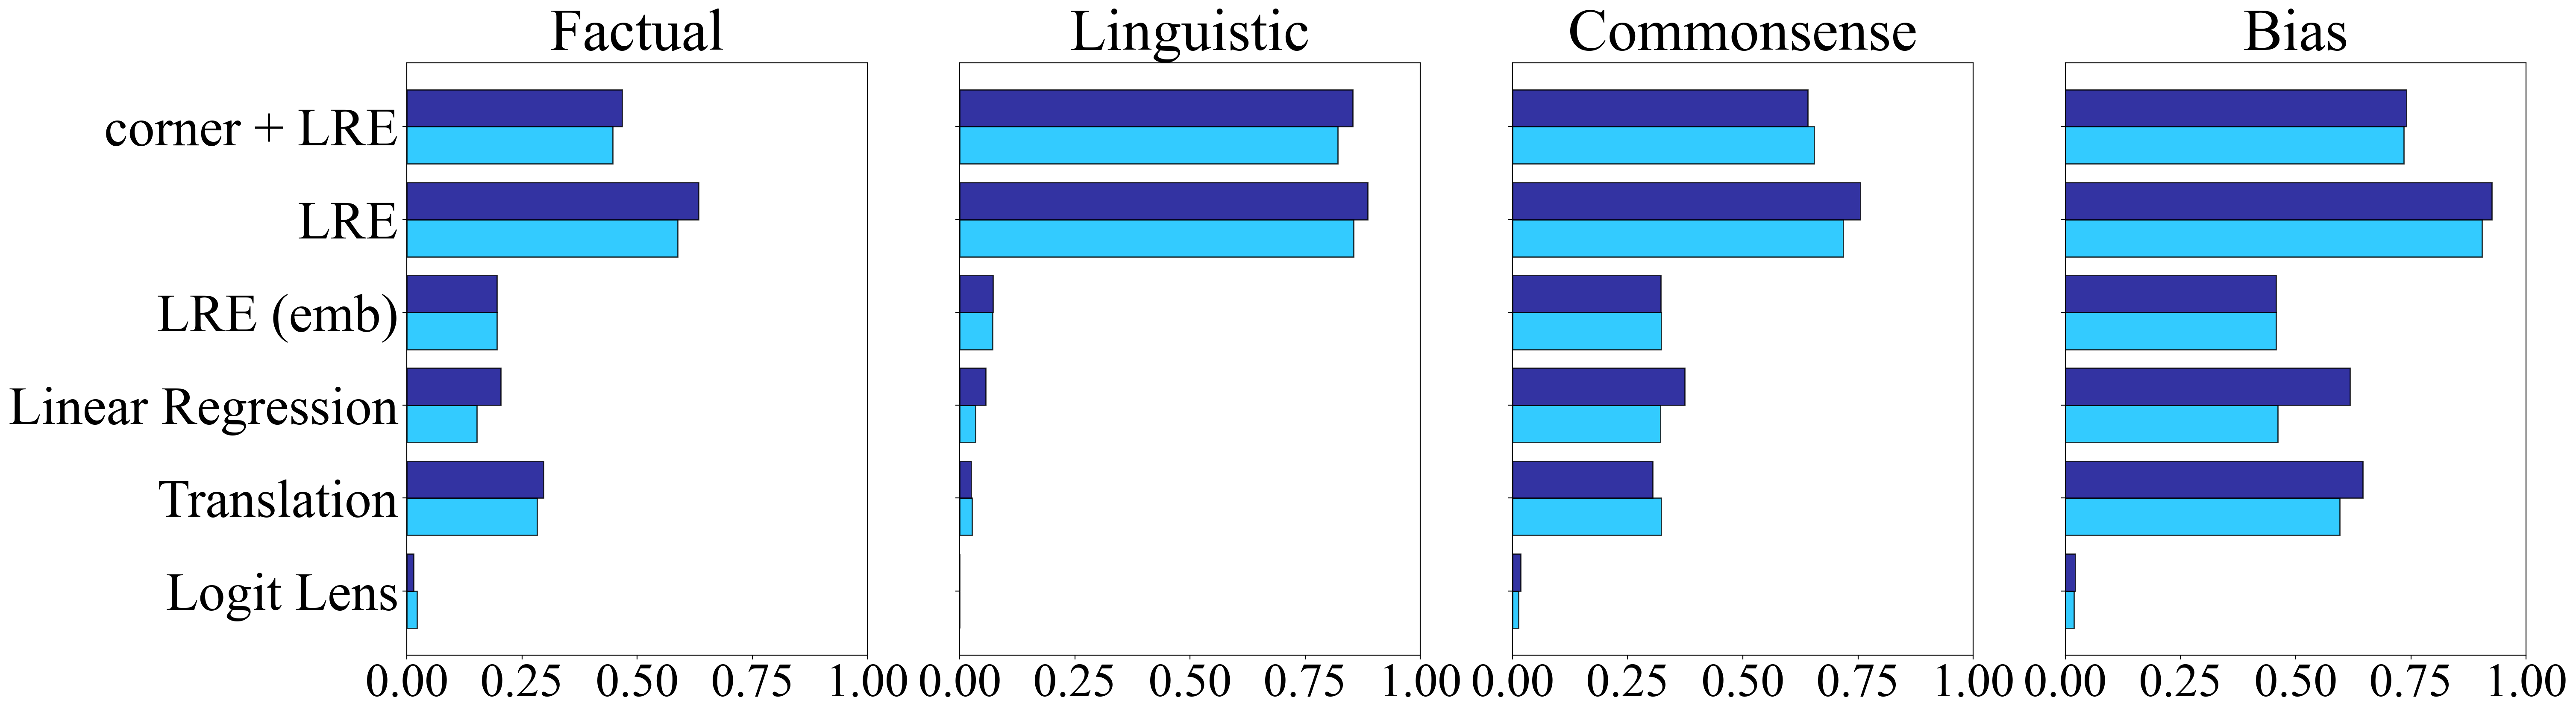

In [24]:
n_subplots = len(performance_category_wise)
ncols=4
nrows=int(np.ceil(n_subplots / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 9))
if nrows == 1:
    axes = [axes]
if ncols == 1:
    axes = [[ax] for ax in axes]

ax_col, ax_row = 0, 0
for i, (category, result) in enumerate(performance_category_wise.items()):
    plot_categorywise(canvas = axes[ax_row][ax_col], result = result, title = category, set_yticks = ax_col == 0)
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1
    # break

# plt.savefig(f"{fig_dir}/faithfulness_lre_methods.pdf", bbox_inches="tight")
fig.show()

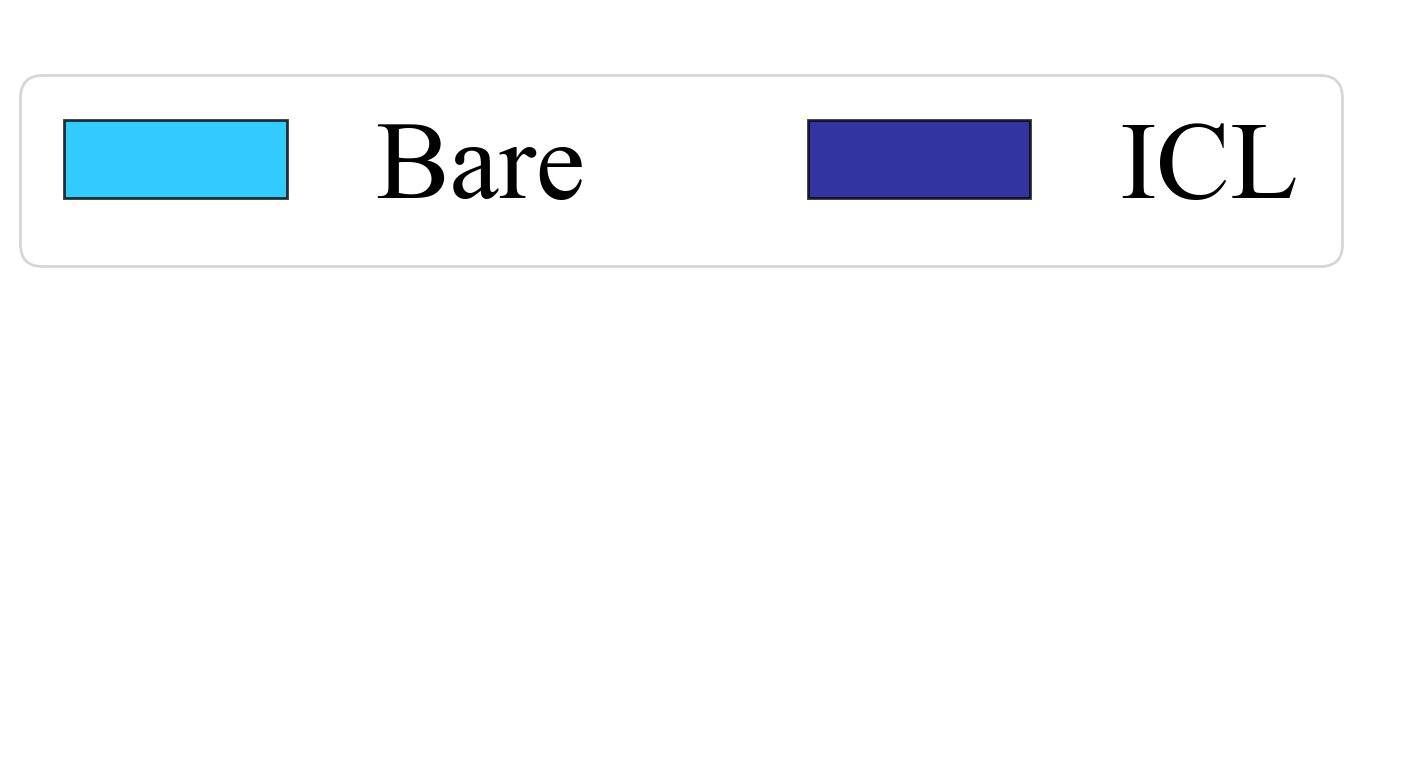

In [20]:
import matplotlib as mpl
palette = dict(zip(['Bare', "ICL"], ['deepskyblue', 'darkblue']))
handles = [mpl.patches.Patch(facecolor=palette[x], label=x, edgecolor="black", alpha=0.8) for x in palette.keys()]
# Create legend
plt.legend(handles=handles, ncols=2)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.savefig(f"{fig_dir}/legend_faithfulness_lre.pdf", format="pdf", bbox_inches="tight")

In [24]:
MODELS = ["gpt2-xl", "gptj", "llama"]
categorywise_results = {}

for model_name in MODELS:
    results_file = f"{sweep_root}/{model_name}.json"
    with open(results_file, "r") as f:
        results_raw = json.load(f)
    results_formatted = format_results(results_raw)

    category_wise = segregate_categorywise(results_formatted, "relation_type")
    for category in category_wise:
        category_wise[category] = category_wise[category]['icl']["lre"][0]
    
    for category in category_wise:
        if category not in categorywise_results:
            categorywise_results[category] = {}
        categorywise_results[category][model_name] = category_wise[category]

categorywise_results

{'bias': {'gpt2-xl': 0.7488597893092455,
  'gptj': 0.777740174479305,
  'llama': 0.814759636911098},
 'commonsense': {'gpt2-xl': 0.5440416088105577,
  'gptj': 0.6476391702868759,
  'llama': 0.6073793839435843},
 'factual': {'gpt2-xl': 0.5200388291603657,
  'gptj': 0.5446967853526435,
  'llama': 0.5752421157740446},
 'linguistic': {'gpt2-xl': 0.7528060933930429,
  'gptj': 0.7888488428347872,
  'llama': 0.7820837124219032}}

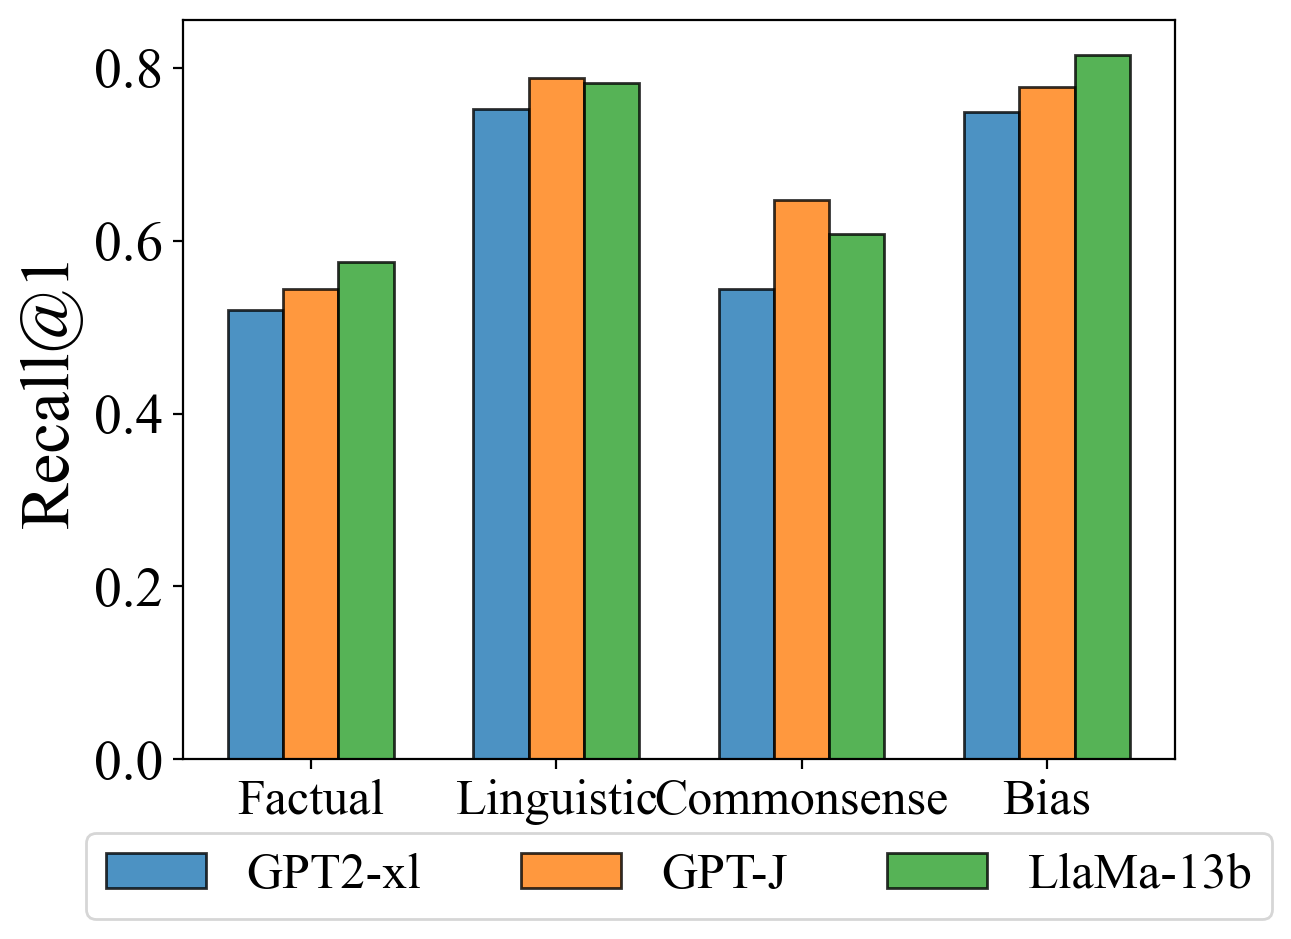

In [25]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+5)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################


n_subplots = len(categorywise_results)
ncols=n_subplots
nrows=int(np.ceil(n_subplots / ncols))

category_order = ["factual", "linguistic", "commonsense", "bias"]
models = {"gpt2-xl": "GPT2-xl", "gptj": "GPT-J", 
          "llama": "LlaMa-13b"
          }

idx = 0
bar_width = 0.225
for model in models:
    recalls = []
    for category in category_order:
        recalls.append(categorywise_results[category][model])
    
    plt.bar(
        np.arange(len(recalls)) + idx * bar_width, recalls,
        width = bar_width,
        label = models[model],
        edgecolor = "black",
        alpha = 0.8
    )
    idx += 1

plt.xticks(np.arange(len(recalls)) + bar_width, [cat.capitalize() for cat in category_order])
plt.ylabel("Recall@1")
plt.legend(ncol = 3, bbox_to_anchor=(0.5, -.25), loc='lower center')
plt.savefig(f"{fig_dir}/faithfulness_lre_models.pdf", bbox_inches="tight")
plt.show()

In [26]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 28

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

In [31]:
results_file = f"{sweep_root}/gptj.json"
with open(results_file, "r") as f:
    results_raw = json.load(f)
results_formatted = format_results(results_raw)

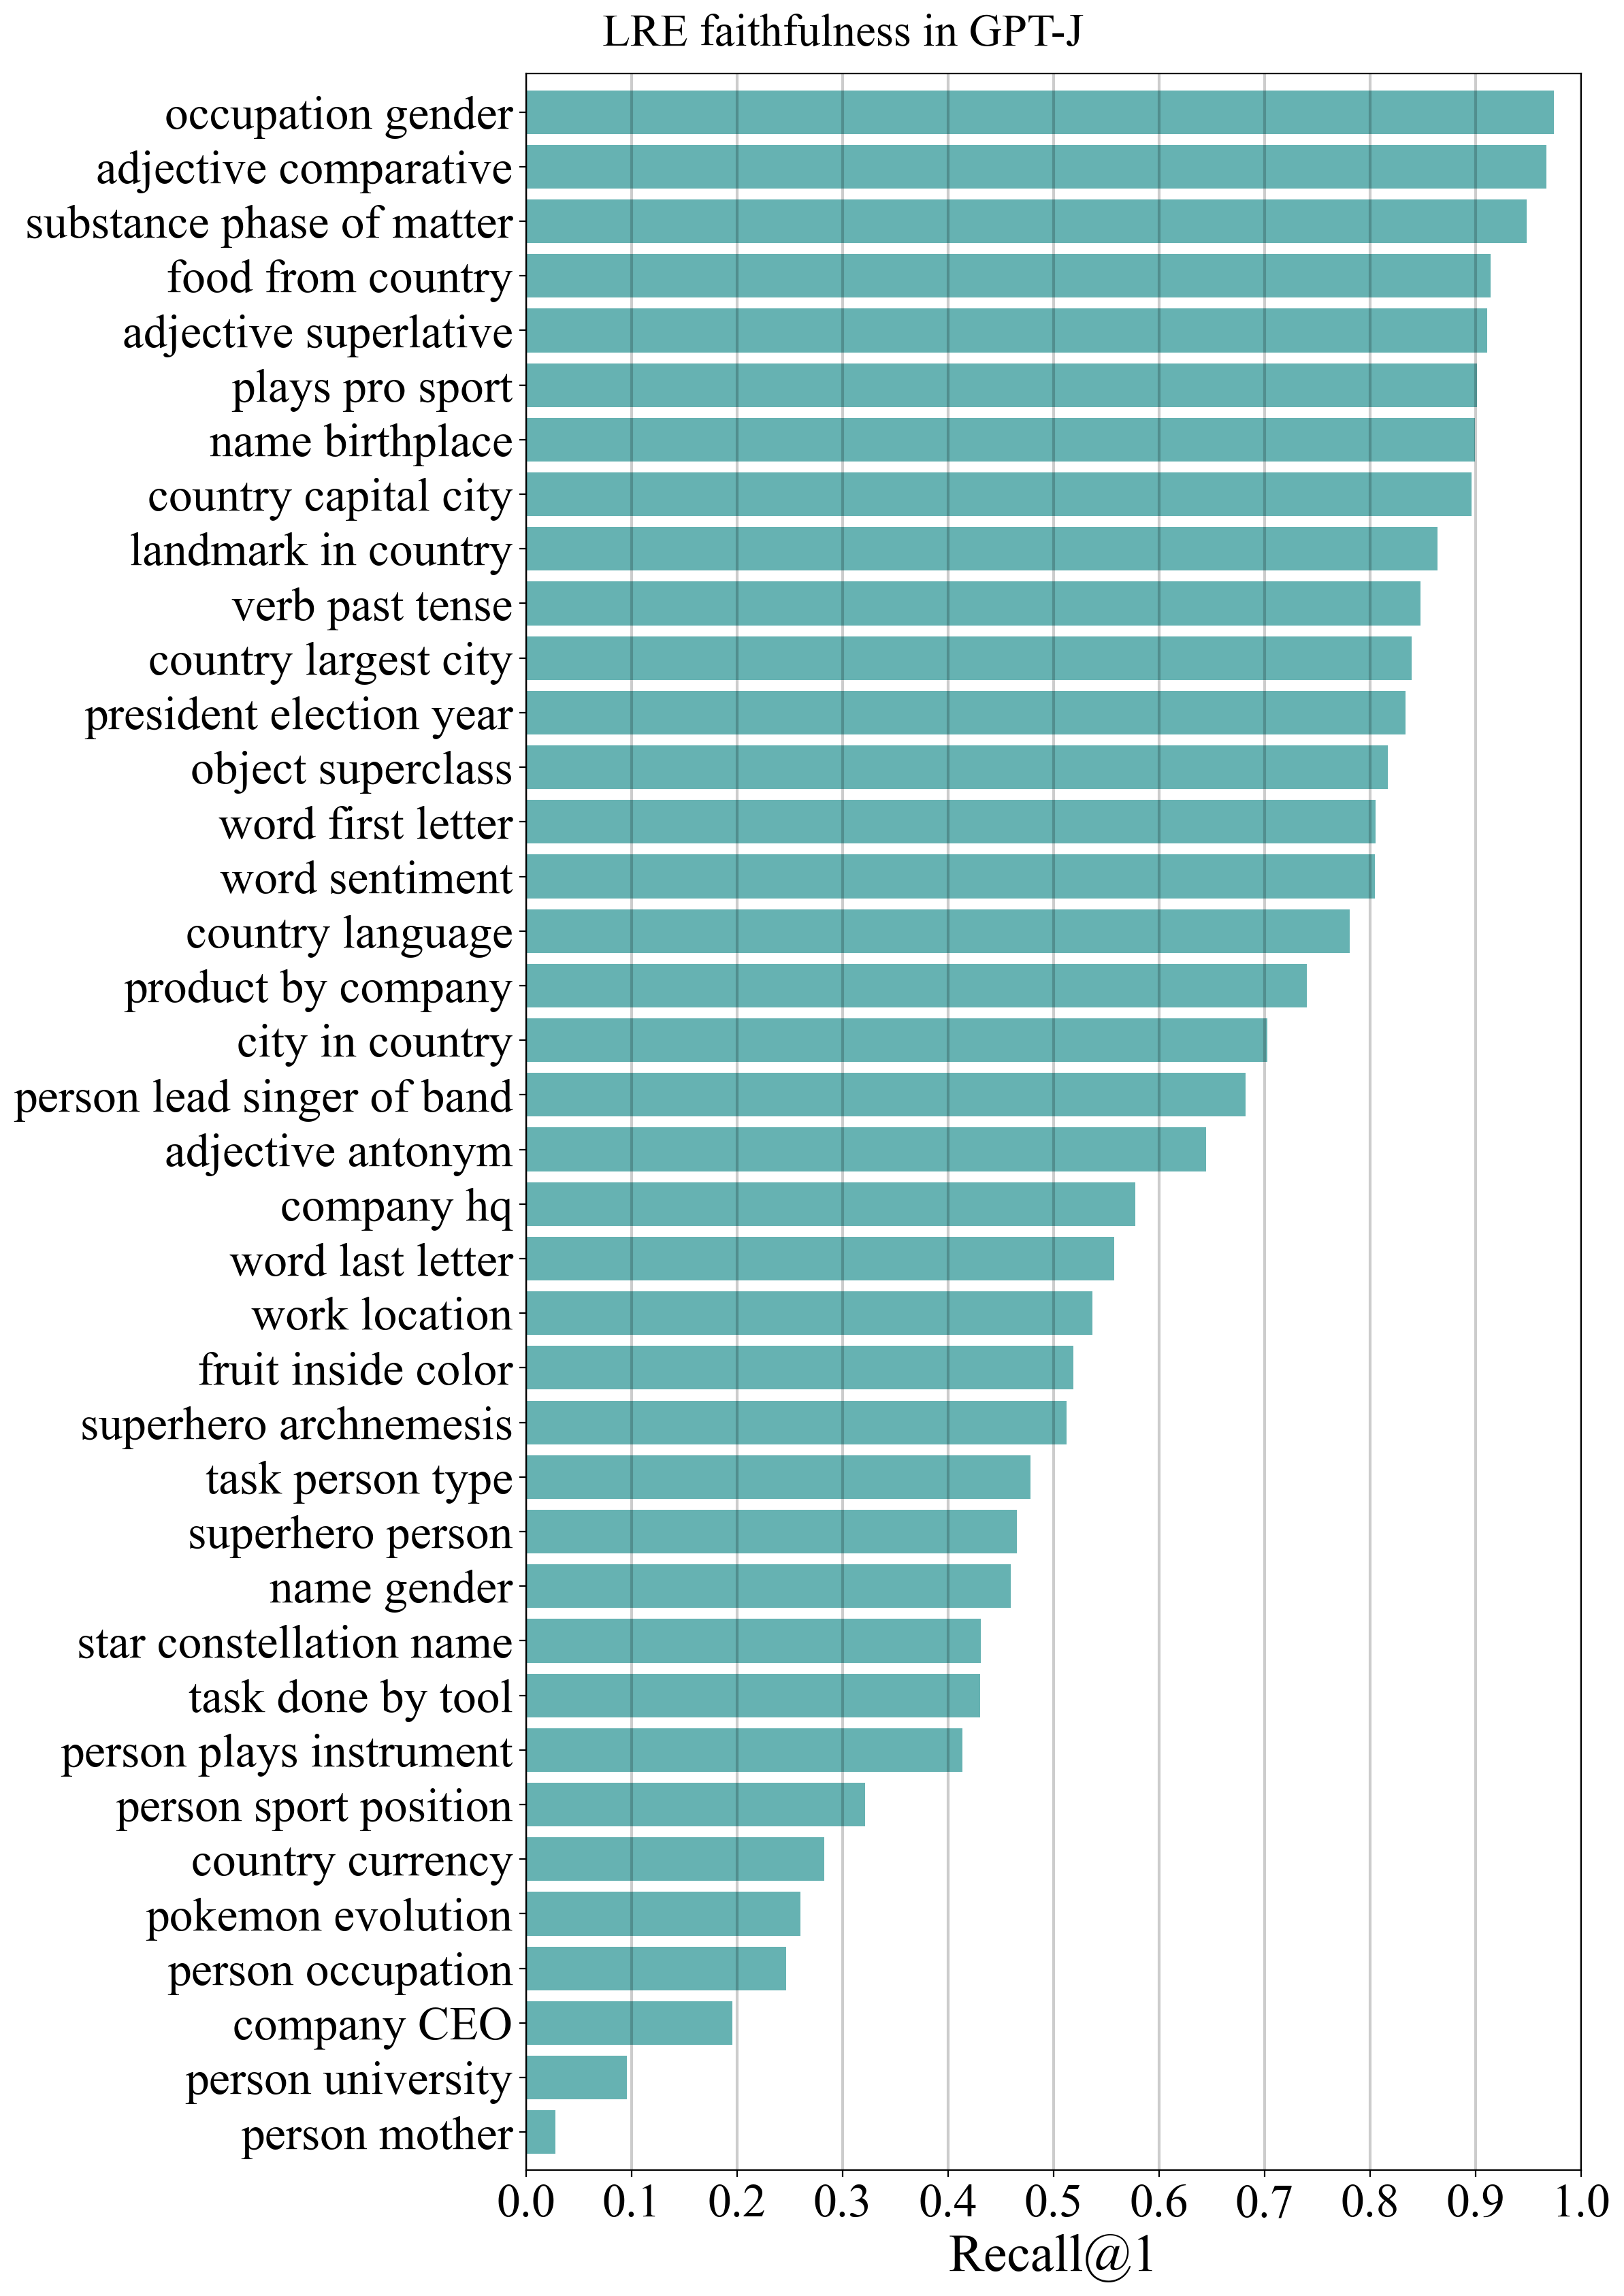

In [32]:
relation_and_recall = []

for relation_name in results_formatted:
    relation_and_recall.append({
        "relation": relation_name,
        "recall@1": results_formatted[relation_name]["recall"]['icl']["lre"][0]
    })

relation_and_recall = sorted(relation_and_recall, key = lambda x: x["recall@1"])

relations = [r["relation"] for r in relation_and_recall]
recalls = [r["recall@1"] for r in relation_and_recall]

plt.figure(figsize = (10, 20))
plt.barh(np.arange(len(relations)), recalls, color = "teal", alpha = 0.6)
plt.yticks(np.arange(len(relations)), relations)
plt.xticks(np.linspace(0, 1, 11), [np.round(v, 1) for v in np.linspace(0, 1, 11)])
plt.ylim(-0.7,len(relation_and_recall)-.3)
plt.xlabel("Recall@1")
plt.xlim(0, 1)

for x_tick in np.linspace(0, 1, 11):
    plt.axvline(x_tick, color = "black", alpha = 0.2)

plt.title("LRE faithfulness in GPT-J", x = 0.3, pad=15)
# plt.savefig(f"{fig_dir}/faithfulness_lre_relationwise.pdf", bbox_inches="tight")
plt.show()